In [25]:
!pip install torch==2.3.1 torchtext==0.18.0 portalocker

In [26]:
%cd /content/
!git clone  https://github.com/NgThanhNhanf/NLP.git

/content
fatal: destination path 'NLP' already exists and is not an empty directory.


In [27]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 131.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [28]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 121.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


After downloading, you can re-run the initialization cell (`b2bf295b`) to confirm that Spacy loads the models correctly.

In [29]:
%cd /content/NLP

/content/NLP


In [30]:
!pip install -r requirements.txt

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from src.model_base import Encoder, Decoder, Seq2Seq
from src.model_attention import EncoderAttention, DecoderAttention, Seq2SeqAttention
from src.dataset import get_data_loaders, build_vocab_and_tokenizers

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Thiết bị đang sử dụng: {device}')

Thiết bị đang sử dụng: cuda


In [32]:
print("Đang xử lý dữ liệu...")

# 1. Đường dẫn file (Đảm bảo bạn đã đổi tên file thành test.en, test.fr như mình dặn)
SRC_FILE = 'data/raw/train.en'
TRG_FILE = 'data/raw/train.fr'

# 2. Xây dựng Vocab & Tokenizer
src_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
trg_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')

src_vocab, trg_vocab = build_vocab_and_tokenizers(src_tokenizer, trg_tokenizer)

# 3. Tạo Iterators (DataLoaders)
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = get_data_loaders(batch_size=BATCH_SIZE, en_tokenizer = src_tokenizer, fr_tokenizer = trg_tokenizer,
                                                                 src_vocab = src_vocab,  trg_vocab = trg_vocab)

print(f"Số lượng câu Train: {len(train_iterator) * BATCH_SIZE}")
print(f"Kích thước từ điển Anh: {len(src_vocab)}")
print(f"Kích thước từ điển Pháp: {len(trg_vocab)}")

Đang xử lý dữ liệu...
Đang xây dựng từ điển (Vocabulary)...
Đang tạo Dataset...
Đang tạo DataLoader...
Số lượng câu Train: 29024
Kích thước từ điển Anh: 5893
Kích thước từ điển Pháp: 6471


In [33]:
# Xem bên trong từ điển
src_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [34]:
# --- HYPERPARAMETERS ---
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# --- KHỞI TẠO ---
enc = EncoderAttention(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAttention(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2SeqAttention(enc, dec, device).to(device)

# --- KHỞI TẠO TRỌNG SỐ (WEIGHTS) ---
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Mô hình có {count_parameters(model):,} tham số có thể huấn luyện')

Mô hình có 22,941,511 tham số có thể huấn luyện


In [35]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Bỏ qua padding token khi tính loss
TRG_PAD_IDX = trg_vocab['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [36]:
def train(model, train_loader, val_loader, criterion, optimizer,
                        num_epochs, device, clip=1.0, teacher_forcing_ratio=0.5,
                        patience=3, model_path='best_model.pth'):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"Bắt đầu training với {num_epochs} epochs")
    print(f"Teacher forcing ratio: {teacher_forcing_ratio}")
    print(f"Gradient clip: {clip}")
    print(f"Early stopping patience: {patience}")
    print("=" * 60)

    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        epoch_train_loss = 0
        batch_count = 0

        # Progress bar
        print(f"\nEpoch {epoch+1}/{num_epochs} - Training...")

        for batch_idx, (source, target, source_lengths) in enumerate(train_loader):
            source, target = source.to(device), target.to(device)
            source_lengths = source_lengths.to(device)

            optimizer.zero_grad()

            # Forward với teacher forcing
            output = model(source, target, source_lengths, teacher_forcing_ratio)

            # Tính loss
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target = target[:, 1:].reshape(-1)

            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping với tham số
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

            optimizer.step()

            epoch_train_loss += loss.item()
            batch_count += 1

            # In progress mỗi 50 batch
            if batch_idx % 50 == 0:
                print(f"   Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / batch_count
        train_losses.append(avg_train_loss)

        # === VALIDATION PHASE ===
        print(f"Epoch {epoch+1}/{num_epochs} - Validating...")
        model.eval()
        epoch_val_loss = 0
        batch_count_val = 0

        # Lấy một batch từ DataLoader
        batch = next(iter(val_loader))

        print(f"Số phần tử trong batch: {len(batch)}")
        print(f"Kiểu dữ liệu batch: {type(batch)}")

        # Kiểm tra từng phần tử
        for i, item in enumerate(batch):
            print(f"  Phần tử {i}: type={type(item)}, shape={item.shape if hasattr(item, 'shape') else len(item)}")

        with torch.no_grad():
            for source, target, source_lengths in val_loader:
                source, target = source.to(device), target.to(device)

                # Evaluation: teacher forcing = 0
                output = model(source, target, source_lengths, teacher_forcing_ratio=0)

                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                target = target[:, 1:].reshape(-1)

                loss = criterion(output, target)
                epoch_val_loss += loss.item()
                batch_count_val += 1

        avg_val_loss = epoch_val_loss / batch_count_val
        val_losses.append(avg_val_loss)

        # === IN KẾT QUẢ ===
        print(f"\n Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Val Loss:   {avg_val_loss:.4f}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # === EARLY STOPPING & SAVE BEST MODEL ===
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, model_path)
            print(f"   Best model saved! (Loss: {avg_val_loss:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"   No improvement ({patience_counter}/{patience})")

            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                print(f"   Best validation loss: {best_val_loss:.4f}")
                break

        print("-" * 60)

    print(f"\n Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Total epochs trained: {len(train_losses)}")

    return train_losses, val_losses

In [37]:
N_EPOCHS = 20 # Số epoch
CLIP = 1

train_losses, val_losses = train(model, train_iterator, valid_iterator,
                                 criterion, optimizer,
                                 N_EPOCHS, device, clip=CLIP,
                                 teacher_forcing_ratio=0.5,
                                 patience=3, model_path='best_model.pth')

Bắt đầu training với 20 epochs
Teacher forcing ratio: 0.5
Gradient clip: 1
Early stopping patience: 3

Epoch 1/20 - Training...
   Batch 0/907, Loss: 8.7694
   Batch 50/907, Loss: 5.1366
   Batch 100/907, Loss: 5.0474
   Batch 150/907, Loss: 4.9315
   Batch 200/907, Loss: 5.0107
   Batch 250/907, Loss: 4.8588
   Batch 300/907, Loss: 4.8253
   Batch 350/907, Loss: 4.4770
   Batch 400/907, Loss: 4.7903
   Batch 450/907, Loss: 4.3437
   Batch 500/907, Loss: 4.6882
   Batch 550/907, Loss: 4.3040
   Batch 600/907, Loss: 4.0818
   Batch 650/907, Loss: 4.4471
   Batch 700/907, Loss: 4.1738
   Batch 750/907, Loss: 4.2970
   Batch 800/907, Loss: 4.2492
   Batch 850/907, Loss: 3.8337
   Batch 900/907, Loss: 4.0845
Epoch 1/20 - Validating...
Số phần tử trong batch: 3
Kiểu dữ liệu batch: <class 'tuple'>
  Phần tử 0: type=<class 'torch.Tensor'>, shape=torch.Size([32, 27])
  Phần tử 1: type=<class 'torch.Tensor'>, shape=torch.Size([32, 27])
  Phần tử 2: type=<class 'torch.Tensor'>, shape=torch.Size(

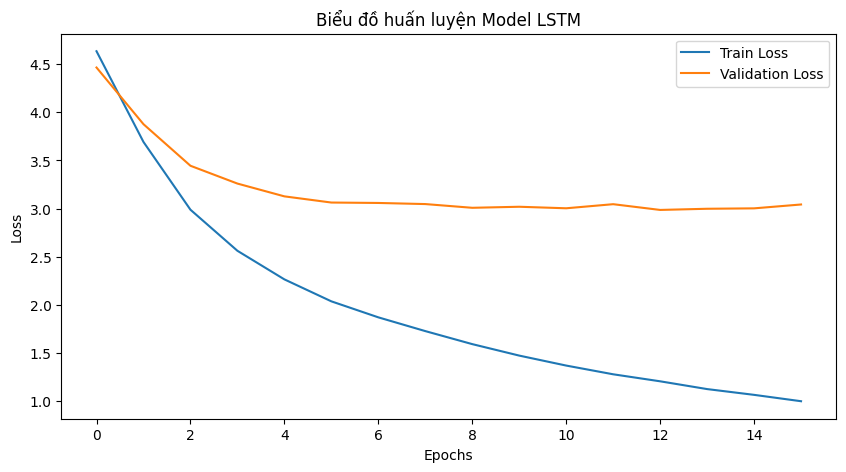

In [38]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Biểu đồ huấn luyện Model LSTM')
plt.savefig('loss_chart.png')
plt.show()

In [39]:
from src.dataset import TranslationDataset, build_vocab_and_tokenizers

# 1. Lấy lại bộ từ điển và tokenizer
# src_vocab, trg_vocab = build_vocab_and_tokenizers()

# 2. Khởi tạo lại biến test_dataset thủ công
print("Đang tải lại tập Test để lấy ví dụ...")
test_dataset = TranslationDataset(
    'data/raw/test_2016_flickr.en',
    'data/raw/test_2016_flickr.fr',
    src_vocab, trg_vocab, src_tokenizer, trg_tokenizer
)

print(f"--> Đã tải xong test_dataset với {len(test_dataset)} câu.")
# Load model tốt nhất
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

def translate_sentence(sentence, src_tokenizer, model, device, max_len=50):
    model.eval()

    # 1. Tokenize
    if isinstance(sentence, str):
        tokens = src_tokenizer(sentence)
    else:
        tokens = sentence

    # 2. Convert to index
    src_indexes = [src_vocab['<sos>']] + [src_vocab[t] for t in tokens] + [src_vocab['<eos>']]

    # 3. Tensor hóa
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)  # [1, seq_len]
    src_len = torch.tensor([len(src_indexes)], dtype=torch.long).to(device)

    # 4. Encode
    with torch.no_grad():
        encoder_outputs, encoder_hidden, encoder_cell = model.encoder(src_tensor, src_len)

    # decoder hidden/cell init
    hidden = encoder_hidden
    cell = encoder_cell

    # 5. Bắt đầu decode
    trg_indexes = [trg_vocab['<sos>']]

    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).unsqueeze(0).to(device)  # [1,1]

        with torch.no_grad():
            output, hidden, cell, _ = model.decoder(
                trg_tensor,      # [1,1]
                hidden,          # hidden state
                cell,            # cell state
                encoder_outputs   # context cố định từ encoder
            )

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = [trg_vocab.lookup_token(i) for i in trg_indexes]

    return trg_tokens[1:-1]   # bỏ <sos> và <eos>


# Thử dịch 1 câu trong tập test

# 1. Chọn index
example_idx = 10

# 2. Lấy trực tiếp từ list chứa text thô (Raw text)
src = test_dataset.src_data[example_idx].strip()
trg = test_dataset.trg_data[example_idx].strip()

print(f'Src: {src}')
print(f'Trg: {trg}')

# 3. Dịch
translation = translate_sentence(src, src_tokenizer, model, device)

print(f'Pred: {" ".join(translation)}')

Đang tải lại tập Test để lấy ví dụ...
--> Đã tải xong test_dataset với 1000 câu.
Src: A mother and her young song enjoying a beautiful day outside.
Trg: Une mère et son jeune fils profitant d'une belle journée dehors.
Pred: une mère mère et sa jeune jeune jeune profitant d' une belle journée .


In [40]:
import torch.nn.functional as F

def translate_sentence_beam(
    sentence,
    src_tokenizer,
    src_vocab,
    trg_vocab,
    model,
    device,
    beam_size=5,
    max_len=50
):
    model.eval()

    # --- Encode ---
    tokens = src_tokenizer(sentence.lower())
    src_indexes = (
        [src_vocab['<sos>']] +
        [src_vocab[t] for t in tokens] +
        [src_vocab['<eos>']]
    )

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_len = torch.tensor([len(src_indexes)]).to(device)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    # --- Beam init ---
    beams = [{
        "tokens": [trg_vocab['<sos>']],
        "hidden": hidden,
        "cell": cell,
        "log_prob": 0.0
    }]

    completed = []

    # --- Decode ---
    for _ in range(max_len):
        new_beams = []

        for beam in beams:
            last_token = beam["tokens"][-1]

            if last_token == trg_vocab['<eos>']:
                completed.append(beam)
                continue

            trg_tensor = torch.LongTensor([[last_token]]).to(device)

            with torch.no_grad():
                output, hidden, cell, attn = model.decoder(
                    trg_tensor,
                    beam["hidden"],
                    beam["cell"],
                    encoder_outputs
                )

            log_probs = F.log_softmax(output, dim=1)
            topk_log_probs, topk_ids = log_probs.topk(beam_size)

            for i in range(beam_size):
                new_beams.append({
                    "tokens": beam["tokens"] + [topk_ids[0, i].item()],
                    "hidden": hidden,
                    "cell": cell,
                    "log_prob": beam["log_prob"] + topk_log_probs[0, i].item()
                })

        beams = sorted(
            new_beams,
            key=lambda x: x["log_prob"],
            reverse=True
        )[:beam_size]

        if len(beams) == 0:
            break

    completed += beams
    best = max(completed, key=lambda x: x["log_prob"])

    trg_tokens = [
        trg_vocab.lookup_token(i)
        for i in best["tokens"]
    ]

    return trg_tokens[1:-1]


In [41]:
src = test_dataset.src_data[10].strip()
translation = translate_sentence_beam(
    src,
    src_tokenizer,
    src_vocab,
    trg_vocab,
    model,
    device,
    beam_size=5
)

print("Pred:", " ".join(translation))

Pred: une mère et son jeune jeune profitant d' une belle journée ensoleillée .


In [42]:
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

def calculate_bleu(data, model, device, max_len=50):
    trgs = []
    pred_trgs = []

    # Chuyển model sang chế độ đánh giá
    model.eval()

    print(f"Đang tính toán BLEU trên {len(data)} câu...")
    for i in tqdm(range(len(data)), desc="Translating"):

        # 1. Lấy câu gốc và câu đích dạng chuỗi
        src_raw = data.src_data[i].strip()
        trg_raw = data.trg_data[i].strip()

        # 2. Model dịch và trả về list token
        pred_trg = translate_sentence(src_raw, src_tokenizer, model, device, max_len)

        # 3. Tokenize câu đích (Ground Truth)
        if isinstance(trg_raw, str):
            trg_tokenized = trg_tokenizer(trg_raw)
        else:
            trg_tokenized = list(trg_raw)

        # --- Làm sạch (Filter) ---
        ignore_tokens = ["<sos>", "<eos>", "<pad>", "<unk>"]

        pred_trg_clean = [tok for tok in pred_trg if tok not in ignore_tokens]
        trg_tokenized_clean = [tok for tok in trg_tokenized if tok not in ignore_tokens]

        # 4. Thêm vào list theo đúng format torchtext yêu cầu
        pred_trgs.append(pred_trg_clean)
        trgs.append([trg_tokenized_clean])

    # --- Tính BLEU ---
    return bleu_score(pred_trgs, trgs)
score = calculate_bleu(test_dataset, model, device)
print(f"\nBLEU score = {score*100:.2f}")

Đang tính toán BLEU trên 1000 câu...


Translating: 100%|██████████| 1000/1000 [00:14<00:00, 66.80it/s]



BLEU score = 35.21
